# Desafio - Regressão Linear Múltipla

## Sobre o desafio

O objetivo deste exercício é construir um modelo de machine learning capaz de prever o valor do aluguel de um imóvel com base em suas características. Através da análise de um dataset de imóveis, você irá:

1. **Explorar os dados:** Realizar uma análise exploratória dos dados para entender a distribuição das variáveis, identificar possíveis outliers e correlações.
2. **Preparar os dados:** Limpar os dados, tratar valores ausentes e codificar variáveis categóricas.
3. **Construir um modelo:** Utilizar um algoritmo de regressão linear para construir um modelo que relacione as características do imóvel com o valor do aluguel.
4. **Avaliar o modelo:** Avaliar a performance do modelo utilizando métricas adequadas e analisar os resíduos para verificar a qualidade das previsões.
5. **Interpretar os resultados:** Analisar os coeficientes do modelo para entender a importância de cada variável na previsão do valor do aluguel.

**Etapas:**

1. **Carregar e explorar o dataset:** Carregue o arquivo CSV fornecido e explore os dados utilizando as funções do pandas.
2. **Pré-processamento:** Realize as seguintes tarefas:
    - Identifique e trate valores ausentes.
    - Remova outliers.
    - Codifique as variáveis categóricas.
    - Escale as variáveis numéricas (se necessário).
3. **Construção do modelo:**
    - Divida os dados em conjuntos de treino e teste.
    - Crie um pipeline para pré-processar os dados e treinar o modelo de regressão linear.
    - Treine o modelo utilizando o conjunto de treino.
4. **Avaliação do modelo:**
    - Faça previsões sobre o conjunto de teste.
    - Calcule métricas de desempenho (R², MAE, RMSE).
    - Analise os resíduos para verificar a qualidade do modelo.
5. **Interpretação dos resultados:**
    - Analise os coeficientes do modelo para entender a importância de cada variável.
    - Discuta as limitações do modelo e sugira possíveis melhorias.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from statsmodels.stats.diagnostic import het_breuschpagan, linear_reset
from scipy.stats import shapiro

## Carga de dados

In [3]:
df_aluguel = pd.read_csv('./data/dataset_aluguel.csv')

In [4]:
df_aluguel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     100 non-null    int64  
 1   tamanho_m2             100 non-null    float64
 2   n_quartos              100 non-null    int64  
 3   idade_casa             100 non-null    float64
 4   garagem                100 non-null    int64  
 5   localizacao_Periferia  100 non-null    bool   
 6   localizacao_Subúrbio   100 non-null    bool   
 7   valor_aluguel          100 non-null    float64
dtypes: bool(2), float64(3), int64(3)
memory usage: 5.0 KB


In [5]:
df_aluguel.describe()

,id,tamanho_m2,n_quartos,idade_casa,garagem,valor_aluguel
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,120.527112,2.910000,25.794810,0.520000,2112.819084
std,29.011492,44.623412,1.400541,14.348628,0.502117,514.314100
min,1.000000,50.828318,1.000000,0.259243,0.000000,1192.728727
25%,25.750000,78.980114,1.750000,13.969405,0.000000,1694.633091
50%,50.500000,119.621368,3.000000,24.827177,1.000000,2069.395680
75%,75.250000,159.530468,4.000000,37.252879,1.000000,2520.182679
max,100.000000,198.033040,5.000000,49.812685,1.000000,3278.742397


In [6]:
df_aluguel.head(10)

,id,tamanho_m2,n_quartos,idade_casa,garagem,localizacao_Periferia,localizacao_Subúrbio,valor_aluguel
0,1,106.181018,1,36.760806,0,True,False,1767.122088
1,2,192.607146,4,10.453581,1,True,False,3278.742397
2,3,159.799091,5,27.072399,1,True,False,2953.899737
3,4,139.798773,4,34.789220,1,False,True,2514.717108
4,5,73.402796,5,11.427501,0,False,True,1942.164396
5,6,73.399178,5,8.747746,1,True,False,2141.303241
6,7,58.712542,3,49.108417,1,True,False,1625.680981
7,8,179.926422,5,25.831795,0,False,True,2854.591908
8,9,140.167252,4,13.041459,1,True,False,2702.673542
9,10,156.210887,5,49.812685,1,False,False,2456.538289


In [7]:
df_aluguel.drop("id", axis=1, inplace=True)

In [8]:
df_aluguel["localizacao_Periferia"] = df_aluguel["localizacao_Periferia"].astype(int)
df_aluguel["localizacao_Subúrbio"] = df_aluguel["localizacao_Subúrbio"].astype(int)

In [9]:
df_aluguel.head(10)

,tamanho_m2,n_quartos,idade_casa,garagem,localizacao_Periferia,localizacao_Subúrbio,valor_aluguel
0,106.181018,1,36.760806,0,1,0,1767.122088
1,192.607146,4,10.453581,1,1,0,3278.742397
2,159.799091,5,27.072399,1,1,0,2953.899737
3,139.798773,4,34.789220,1,0,1,2514.717108
4,73.402796,5,11.427501,0,0,1,1942.164396
5,73.399178,5,8.747746,1,1,0,2141.303241
6,58.712542,3,49.108417,1,1,0,1625.680981
7,179.926422,5,25.831795,0,0,1,2854.591908
8,140.167252,4,13.041459,1,1,0,2702.673542
9,156.210887,5,49.812685,1,0,0,2456.538289


In [10]:
df_aluguel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tamanho_m2             100 non-null    float64
 1   n_quartos              100 non-null    int64  
 2   idade_casa             100 non-null    float64
 3   garagem                100 non-null    int64  
 4   localizacao_Periferia  100 non-null    int64  
 5   localizacao_Subúrbio   100 non-null    int64  
 6   valor_aluguel          100 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 5.6 KB


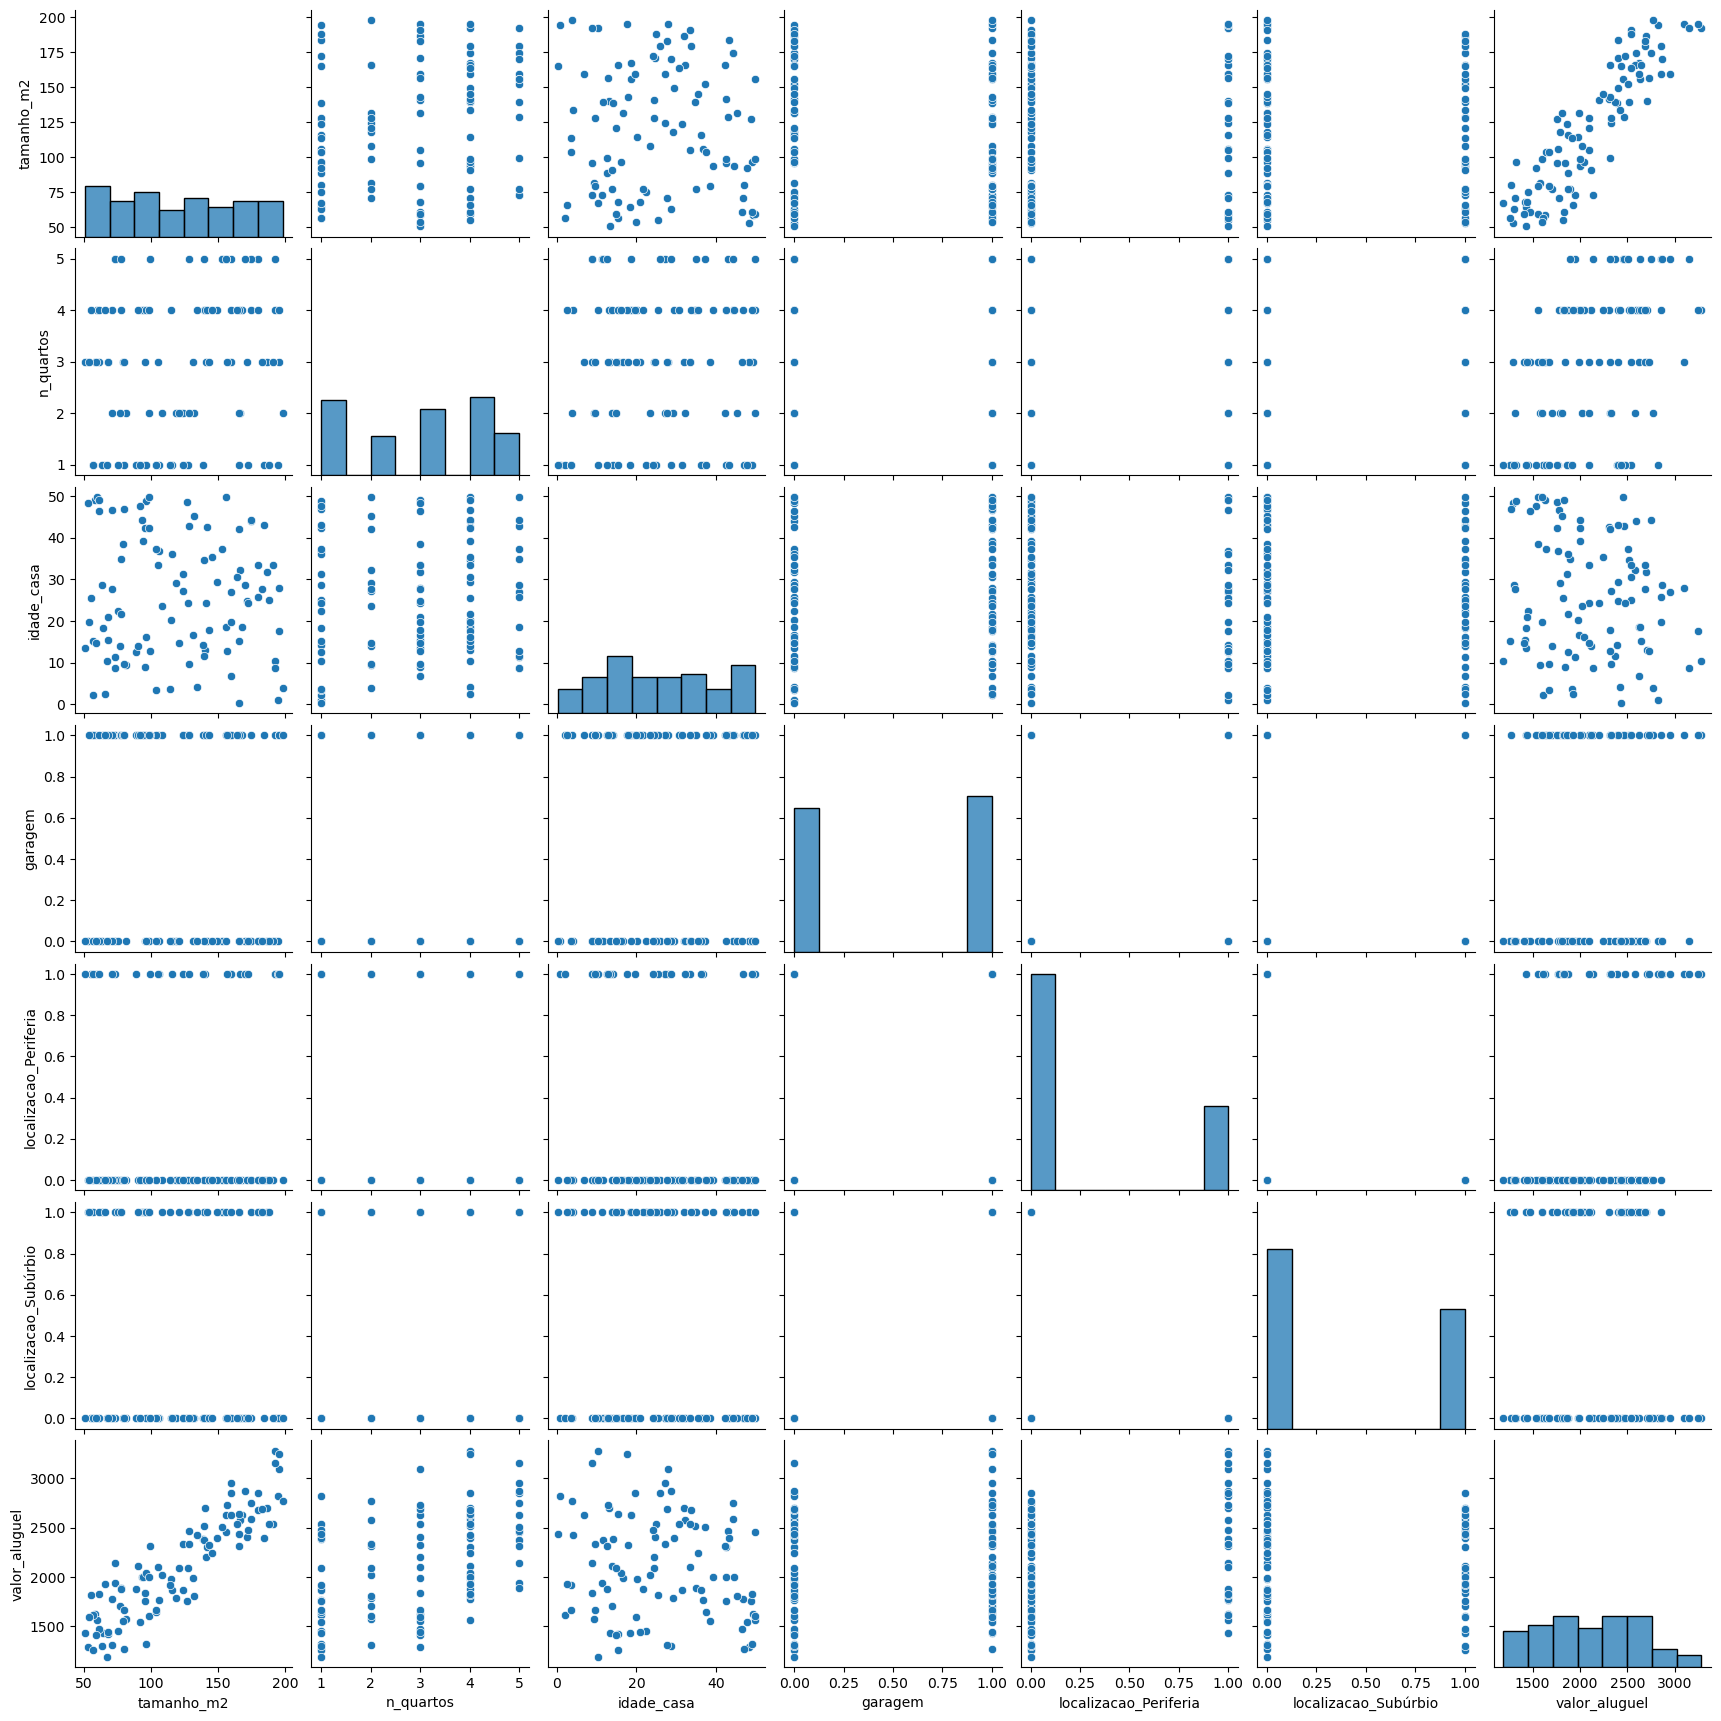

In [11]:
sns.pairplot(df_aluguel)

<Axes: >

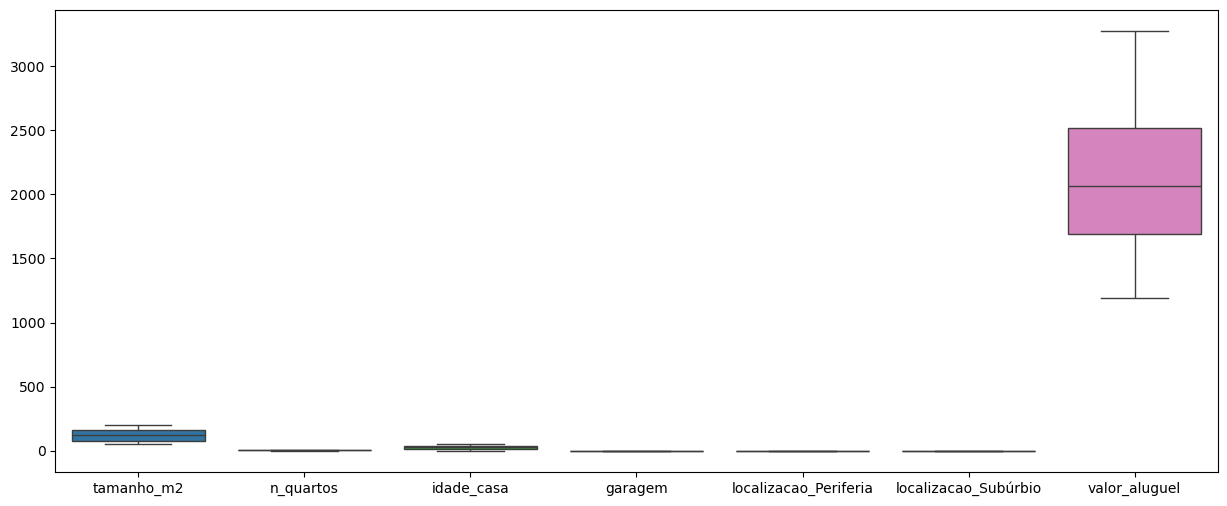

In [12]:
plt.figure(figsize=(15, 6)) 
sns.boxplot(df_aluguel)

In [74]:
colunas_numericas = ['tamanho_m2', 'n_quartos', 'idade_casa', 'garagem']

transformer_numericas = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
   transformers=[
        ('num', transformer_numericas, colunas_numericas)
    ],
     remainder='passthrough'
)

model_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X = df_aluguel.drop("valor_aluguel", axis=1)
y = df_aluguel["valor_aluguel"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores_list = []
mse_scores_list = []
mae_scores_list = []
residuos_list = []
residuos_std_list = []
y_pred_list = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model_reg.fit(X_train, y_train)
    y_pred = model_reg.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    residuos = (y_test - y_pred)
    residuos_std = residuos / residuos.std()

    y_pred_list.append(y_pred)
    r2_scores_list.append(r2)
    mse_scores_list.append(mse)
    mae_scores_list.append(mae)
    residuos_list.append(residuos)
    residuos_std_list.append(residuos_std)

mae = np.mean(mae_scores_list)
mse = np.mean(mse_scores_list)
r2 = np.mean(r2_scores_list)
residuos = np.concatenate(residuos_list)
residuos_std = np.concatenate(residuos_std_list)
all_y_pred = np.concatenate(y_pred_list)

In [75]:
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print("Resíduos:", residuos)
print("Resíduos Padronizados:", residuos_std)

R²: 0.9909
MSE: 2255.6917
MAE: 38.6043
Resíduos: [ -30.27409604   83.56986893   -0.90073312  -48.38737505   18.58106175
    4.6973994   -55.67342623   22.05992329  -28.55618882  -29.97377469
   -1.65633624  -46.962417     -9.17239017  -30.09297779  -40.00564117
  -10.5210912    88.91381606  -45.60365919   84.42124949  -89.27270213
  -14.64783225  -37.59172039   35.35307065  -66.67583435   66.71214446
  -70.52618196   29.46477795   -6.317149    -17.30799309   19.64648096
    8.87177161    5.41593169  -59.93117237    9.26118148  -30.98323292
 -129.73739662  -25.21466392   10.11682665   16.37319631  -48.12182909
   49.72820707   14.54634903   -9.74882517   19.55018645  104.41002927
   41.31314515   31.6873817    41.71193879   -0.61849795  -21.09931279
  -11.40553403  -60.60331722  -38.24366101  -30.9509144    64.57354312
  100.18028342   54.48310181   31.92586217   75.15329754   34.61902871
  -20.21998161   79.63675235   -3.7549029   -47.91930675  -24.55225373
   46.35277196   22.31018979

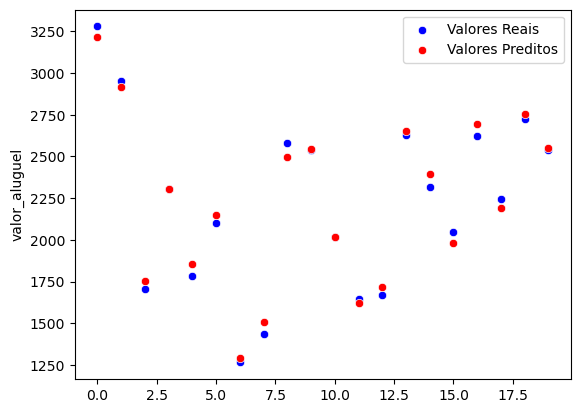

In [76]:
sns.scatterplot(x=range(len(y_test)), y=y_test, color='blue', label='Valores Reais')
sns.scatterplot(x=range(len(y_test)), y=y_pred, color='red', label='Valores Preditos')
plt.legend()
plt.show()

In [ ]:
shapiro_w = shapiro(residuos_list)
shapiro_w # Tudo leva a crer que não rejeita-se a H0  o modelo tem dist. normal

ShapiroResult(statistic=np.float64(0.9889460651906192), pvalue=np.float64(0.5803335674224173))

In [ ]:
# Pré-processamento e ajuste do modelo OLS
X_proc = preprocessor.fit_transform(X)
model_sm = sm.OLS(y, sm.add_constant(X_proc)).fit()

# Teste de linearidade RESET
reset_result = linear_reset(model_sm)
reset_statistic = reset_result.statistic
reset_pvalue = reset_result.pvalue

# Resíduos para teste de heterocedasticidade
residuals = model_sm.resid

# Teste de Breusch-Pagan
bp_test = het_breuschpagan(residuals, model_sm.model.exog)

print('Linear Test p-value:', reset_pvalue)  # p-valor do teste RESET - Não rejeita-se a hipótese nula o modelo é linear
print('Breusch-Pagan test statistic:', bp_test[0])  # estatística LM
print('Breusch-Pagan test p-value:', bp_test[1])    # p-valor - O modelo é Heterocedastico


Linear Test p-value: 0.31780079782328696
Breusch-Pagan test statistic: 12.943065309884261
Breusch-Pagan test p-value: 0.043949036413945555


In [79]:
model_robust = model_sm.get_robustcov_results(cov_type='HC0')

print(model_robust.summary())

                            OLS Regression Results                            
Dep. Variable:          valor_aluguel   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     2482.
Date:                Tue, 30 Sep 2025   Prob (F-statistic):          2.64e-100
Time:                        16:57:55   Log-Likelihood:                -516.40
No. Observations:                 100   AIC:                             1047.
Df Residuals:                      93   BIC:                             1065.
Df Model:                           6                                         
Covariance Type:                  HC0                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1960.3306      7.849    249.767      0.0

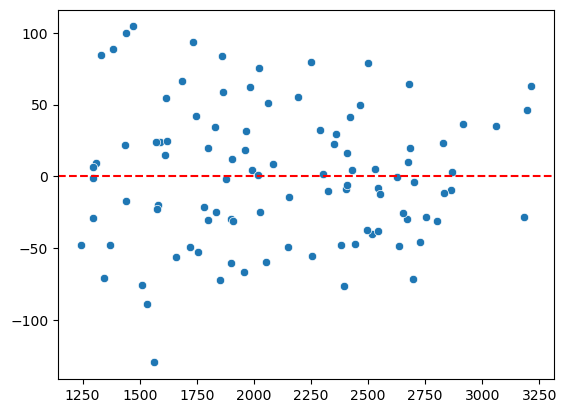

In [ ]:
sns.scatterplot(x=all_y_pred, y=residuos)
plt.axhline(y=0, color='r', linestyle='--') # Pelo gráfico é heterocedástico
# residuos.reshape(-1), y_pred.reshape(-1)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

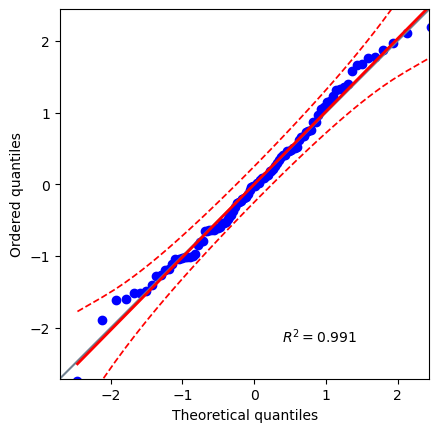

In [ ]:
pg.qqplot(x=residuos, dist='norm', confidence=0.95) # Pelo gráfico é linear

## Avaliação do modelo
- Há presença de heterocedasticidade no modelo o que foi resolvido com erros robustos de white ajustando os erros e as variáveis mantiveran-se significantes.
- Há princípio o modelo é linear sendo a escolha da regressão multipla adequada
- Seria melhor ter mais dados com maior variabilidade para que pudessemos verificar se realmente aquele R^2 ajustado de 93% está correto
- Aparentemente as características dos imóveis influenciam no valor e com isso é possível prever os valores de aluguel.
- As duas variáveis que mais influenciam o modelo são: 
    - O valor
    - O localização na periferia (da para ver essa correlação no gráfico mas nada garante que em média as casas na periferia não sejam maiores em média etc teria que verificar isso)

- Obs: Não notei nenhum outliers olhando para o boxplot
- Não criei dummys pois na literatura não é aconselhável cria-las na mão, só transformei em 0 ou 1 os booleanos e deixe que fosse interpretado